This is the desired end goal should look:
<br>(taken from IMP)

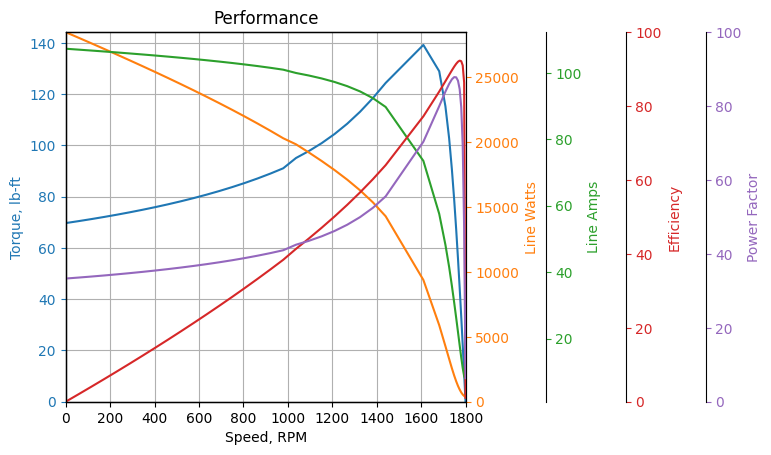

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# pull data from IMP run
imp_data = {}
with open("C:\\Users\\USTRCAJ\\AppData\\Roaming\\EngineeringToolboxOne\\NameValue.dat") as file:
    for line in file:
        label, value = line.split(';')
        value = value.lstrip().strip('\n')

        imp_data[label] = value

rpm = []
torq = []
watts = []
amps = []
eff = []
pf = []

pri = []
sec = []
core = []

for i in range(1, 40):
    rpm.append(float(imp_data['RPM'+str(i)]))
    torq.append(float(imp_data['TMU'+str(i)]))
    watts.append(float(imp_data['WLT'+str(i)]))
    amps.append(float(imp_data['IL'+str(i)]))
    eff.append(float(imp_data['EFF'+str(i)]))
    pf.append(float(imp_data['PF'+str(i)]))

    pri.append(float(imp_data['WLP'+str(i)]))
    sec.append(float(imp_data['WLS'+str(i)]))
    core.append(float(imp_data['WI'+str(i)]))

rpm = np.array(rpm)
torq = np.array(torq)
watts = np.array(watts)
amps = np.array(amps)
eff = np.array(eff)
pf = np.array(pf)

pri = np.array(pri)
sec = np.array(sec)
core = np.array(core)

fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin3 = ax.twinx()
twin4 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.2))
twin3.spines.right.set_position(("axes", 1.4))
twin4.spines.right.set_position(("axes", 1.6))

p1, = ax.plot(rpm, torq, "C0", label="Torque, lb-ft")
p2, = twin1.plot(rpm, watts, "C1", label="Line Watts")
p3, = twin2.plot(rpm, amps, "C2", label="Line Amps")
p4, = twin3.plot(rpm, eff, "C3", label="Efficiency")
p5, = twin3.plot(rpm, pf, "C4", label="Power Factor")

ax.set(xlim=(0, 1800), ylim=(0, max(torq)+5), xlabel="Speed, RPM", ylabel="Torque, lb-ft")
twin1.set(ylim=(0, max(watts)+5), ylabel="Line Watts")
twin2.set(ylim=(1, max(amps)+5), ylabel="Line Amps")
twin3.set(ylim=(0, 100), ylabel="Efficiency")
twin4.set(ylim=(0, 100), ylabel="Power Factor")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())
twin3.yaxis.label.set_color(p4.get_color())
twin4.yaxis.label.set_color(p5.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())
twin2.tick_params(axis='y', colors=p3.get_color())
twin3.tick_params(axis='y', colors=p4.get_color())
twin4.tick_params(axis='y', colors=p5.get_color())

ax.grid()
ax.set_title('Performance')

plt.show()

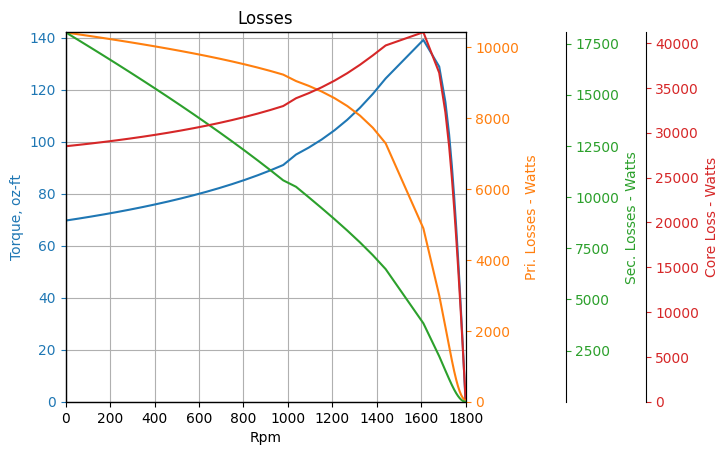

In [59]:
fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin3 = ax.twinx()

twin2.spines.right.set_position(("axes", 1.25))
twin3.spines.right.set_position(("axes", 1.45))

p1, = ax.plot(rpm, torq, "C0", label="Torque, oz-ft")
p2, = twin1.plot(rpm, pri, "C1", label="Pri. Losses - Watts")
p3, = twin2.plot(rpm, sec, "C2", label="Sec. Losses - Watts")
p4, = twin3.plot(rpm, core, "C3", label="Core Loss - Watts")

ax.set(xlim=(0, 1800), ylim=(0, max(torq)+3), xlabel="Rpm", ylabel="Torque, oz-ft")
twin1.set(ylim=(0, max(pri)+10), ylabel="Pri. Losses - Watts")
twin2.set(ylim=(1,  max(sec)+10), ylabel="Sec. Losses - Watts")
twin3.set(ylim=(0, max(core)+10), ylabel="Core Loss - Watts")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())
twin3.yaxis.label.set_color(p4.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())
twin2.tick_params(axis='y', colors=p3.get_color())
twin3.tick_params(axis='y', colors=p4.get_color())

ax.grid()
ax.set_title('Losses')

plt.show()

### My Model

In [2]:
def poly_circuit(volts, ph, x1, x2, xM, r1, r2, rfe, f_w, sync):
    '''
    This function computes the performance of an induction motor given its equivalent
    circuit parameters aka motor constants. 
    Args:
        volts: Phase-voltage value [volts]
        ph:    No. of phases
        x1:    Primary leakage reactance [ohms]
        x2:    Secondary leakage reactance [ohms]
        xM:    Mutual reactance [ohms]
        r1:    Primary resistance [ohms] 
        r2:    Secondary resistance [ohms] 
        rfe:   Resistance for iron losses [ohms]
        f_w:   Friction and windage loss [watts]
        sync:  Synchronous speed of machine [rpm]
    Returns:
        perf:  Dictionary containing performance over range of operating points
    '''
    import numpy as np

    # series core-loss resistance
    rM = xM**2 / (rfe * (1 + (xM/rfe)**2))

    # F-CONSTANTS 
    F1 = x1 + x2 * xM / (xM + x2) - r1 * rM / (xM + x2)
    F2 = r2 * (xM + x1) / (xM + x2)
    F3 = r2 * (r1 + rM) / (xM + x2)
    F4 = rM * (x1 + x2) / (xM + x2) + r1
    F5 = volts * rM / (xM + x2)
    F6 = volts * r2 / (xM + x2)
    F7 = volts * np.sqrt(rM**2 + xM**2) / (xM + x2)
    A10 = volts * x2 / (xM + x2)

    # points calculated: no-load plus operation
    slip_points = [0.0001, 0.0005, 0.001, 0.005] + [abs(round(i, 2)) for i in np.arange(0.01, 1.01, 0.01)] 
    
    # dictionary to hold expected performance data
    perf = {'slip': slip_points,
            'current': [],
            'pri_loss': [],
            'sec_loss': [],
            'core_loss': [],
            'input': [],
            'torque': [],
            'eff': [],
            'pf': []}
    
    for s in slip_points: 
        
        part1 = np.sqrt((F5 + F6 / s)**2 + volts**2)
        part2 = np.sqrt((F3 / s - F1)**2 + (F2 / s + F4)**2)
        
        I = part1 / part2 # primary current
        I2 = F7 / part2 # secondary current
        IM = np.sqrt(((F6/s)**2 + A10**2) / part2**2) # magnetizing current

        pri_loss = I**2 * r1 * ph 
        sec_loss = I2**2 * r2 * ph
        core_loss = IM**2 * rM * ph
        
        if s != 1: 
            sec_output = sec_loss * (1 - s) / s  
            if sec_output > f_w:
                output = sec_output - f_w
            else: output = 0
        else: 
            sec_output = 0
            output = 0
        
        input_ = pri_loss + sec_loss + core_loss + sec_output 
        
        torque = 7.04 * (sec_loss - f_w) / (s * sync) 
            
        eff = output / input_ * 100
        
        pf = input_ / (volts * I * ph) * 100
        
        # add perf for this speed in results dict
        perf['current'].append(I)
        perf['pri_loss'].append(pri_loss)
        perf['sec_loss'].append(sec_loss)
        perf['core_loss'].append(core_loss)
        perf['input'].append(input_)
        perf['torque'].append(torque)
        perf['eff'].append(eff)
        perf['pf'].append(pf)

    return perf

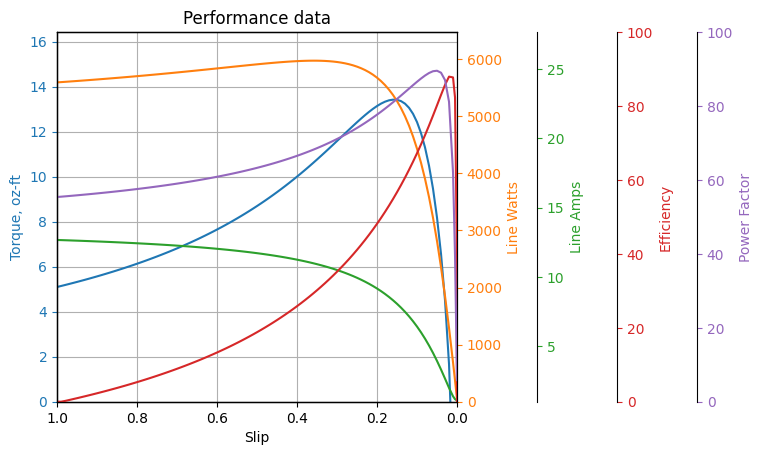

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# call function to create model
motor_data = poly_circuit(
                            volts = 460/np.sqrt(3),
                            ph = 3,
                            x1 = 10.4944,
                            x2 = 7.1384,
                            xM = 229.4160,
                            r1 = 8.8667,
                            r2 = 2.9103,
                            rfe = 15771.7881,
                            f_w = 15,
                            sync = 1800
                        )


# plot perf results
slip = np.array(motor_data['slip'])
torq = np.array(motor_data['torque'])
watts = np.array(motor_data['input'])
amps = np.array(motor_data['current'])
eff = np.array(motor_data['eff'])
pf = np.array(motor_data['pf'])

fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin3 = ax.twinx()
twin4 = ax.twinx()

twin2.spines.right.set_position(("axes", 1.2))
twin3.spines.right.set_position(("axes", 1.4))
twin4.spines.right.set_position(("axes", 1.6))

p1, = ax.plot(slip, torq, "C0", label="Torque, lb-ft")
p2, = twin1.plot(slip, watts, "C1", label="Line Watts")
p3, = twin2.plot(slip, amps, "C2", label="Line Amps")
p4, = twin3.plot(slip, eff, "C3", label="Efficiency")
p5, = twin3.plot(slip, pf, "C4", label="Power Factor")

ax.set(ylim=(0, max(torq)+3), xlabel="Slip", ylabel="Torque, oz-ft")
ax.set_xlim(1, 0)
twin1.set(ylim=(0, max(watts)+500), ylabel="Line Watts")
twin2.set(ylim=(1,  max(amps)+15), ylabel="Line Amps")
twin3.set(ylim=(0, 100), ylabel="Efficiency")
twin4.set(ylim=(0, 100), ylabel="Power Factor")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())
twin3.yaxis.label.set_color(p4.get_color())
twin4.yaxis.label.set_color(p5.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())
twin2.tick_params(axis='y', colors=p3.get_color())
twin3.tick_params(axis='y', colors=p4.get_color())
twin4.tick_params(axis='y', colors=p5.get_color())

ax.grid()
ax.set_title('Performance data')

plt.show()

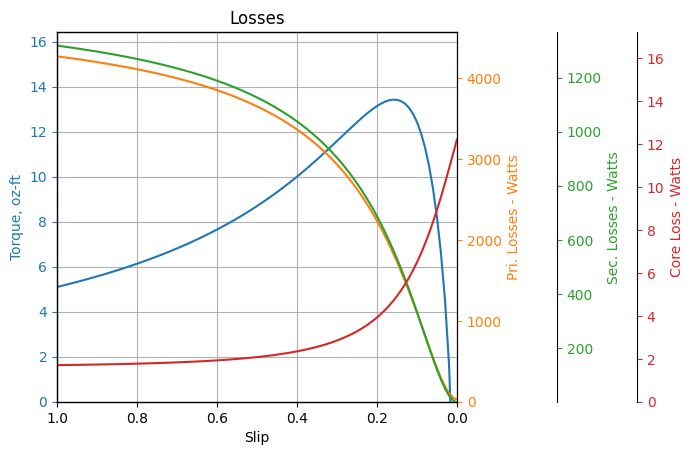

In [4]:
# plot loss results
slip = np.array(motor_data['slip'])
pri = np.array(motor_data['pri_loss'])
sec = np.array(motor_data['sec_loss'])
core = np.array(motor_data['core_loss'])

fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin3 = ax.twinx()

twin2.spines.right.set_position(("axes", 1.25))
twin3.spines.right.set_position(("axes", 1.45))

p1, = ax.plot(slip, torq, "C0", label="Torque, oz-ft")
p2, = twin1.plot(slip, pri, "C1", label="Pri. Losses - Watts")
p3, = twin2.plot(slip, sec, "C2", label="Sec. Losses - Watts")
p4, = twin3.plot(slip, core, "C3", label="Core Loss - Watts")

ax.set(ylim=(0, max(torq)+3), xlabel="Slip", ylabel="Torque, oz-ft")
ax.set_xlim(1, 0)
twin1.set(ylim=(0, max(pri)+300), ylabel="Pri. Losses - Watts")
twin2.set(ylim=(1,  max(sec)+50), ylabel="Sec. Losses - Watts")
twin3.set(ylim=(0, max(core)+5), ylabel="Core Loss - Watts")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())
twin3.yaxis.label.set_color(p4.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())
twin2.tick_params(axis='y', colors=p3.get_color())
twin3.tick_params(axis='y', colors=p4.get_color())

ax.grid()
ax.set_title('Losses')

plt.show()